In [69]:
import pandas as pd
import os
import csv
from functools import reduce
import json
import configparser
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [70]:
# root folder
root_folder = "../../output_data/topic_modelling/run_20230601_113109"
report_folder = os.path.join(root_folder, "reports")
topic_folder = os.path.join(root_folder, "topics")

In [71]:
def get_country_year(filename):
        parts = filename.split("_")
        if len(parts) > 3:
            country = parts[0] + "_" + parts[1]
            year = parts[2]
        else:
            country = parts[0]
            year = parts[1]    
        return (country, year)
        

In [72]:
# load dataframes
dataframes = []
countries = []
years = []

# Iterate over files in the folder
for filename in os.listdir(report_folder):
    if filename.endswith(".csv"):
        country, year = get_country_year(filename)
        if country not in countries:
            countries.append(country)
        if year not in years:
            years.append(year)
            
        file_path = os.path.join(report_folder, filename)
        # Read the CSV file into a pandas DataFrame
        df = pd.read_csv(file_path, header=None)
        df["country"] = country
        df["year"] = year
        df.columns.values[0] = 'attribute'
        df.columns.values[1] = 'topic_no'
        df.columns.values[2] = "word_from_dict"
        df.columns.values[3] = "similarity"
        df.columns.values[4] = "normalized_count"
       
        # Append the DataFrame to the list
        dataframes.append(df)
        
combined_df = pd.concat(dataframes, ignore_index=True)

In [73]:
# load topics
topics_df = []
# Iterate over files in the folder
for filename in os.listdir(topic_folder):
    if filename.endswith(".csv"):
        country, year = get_country_year(filename)        
        file_path = os.path.join(topic_folder, filename)
        # Read the CSV file into a pandas DataFrame
        df = pd.read_csv(file_path)
        df["country"] = country
        df["year"] = year
        #df.columns.values[0] = 'attribute'
        #df.columns.values[1] = 'topic_no'
        #df.columns.values[2] = "word_from_dict"
        #df.columns.values[3] = "similarity"
        #df.columns.values[4] = "normalized_count"
       
        # Append the DataFrame to the list
        topics_df.append(df)
        
combined_topics_df = pd.concat(topics_df, ignore_index=True)
print(combined_topics_df.head())

   Topic_No                                         Topic_Name  Count  \
0         0  0_moldovan law_moldovan authorities_moldova is...     18   
1         1  1_pandemic progressed_the pandemic_19 pandemic...     17   
2         2  2_parliamentary elections_elections_2019 parli...     14   
3         3  3_deportation_detained_plahotniuc extradition_...     13   
4         4    4_opposition before_the pdm_the psrm_opposition     10   

                                         Topic_Words  country  year  
0  [('moldovan law', 0.66324973), ('moldovan auth...  moldova  2021  
1  [('pandemic progressed', 0.63113606), ('the pa...  moldova  2021  
2  [('parliamentary elections', 0.6537092), ('ele...  moldova  2021  
3  [('deportation', 0.4972635), ('detained', 0.47...  moldova  2021  
4  [('opposition before', 0.435781), ('the pdm', ...  moldova  2021  


In [74]:
corpus_df = []
data = {'country':[], 'year': [], 'corpus_size': []}
for country in countries:
    for year in years:
        tdf = combined_topics_df
        df = tdf[(tdf['year'] == year) & (tdf['country'] == country)]
        size = df['Count'].sum()
        data['country'].append(country)
        data['year'].append(year)
        data['corpus_size'].append(size)
        
        
corpus_df = pd.DataFrame(data)
print(corpus_df.head())            

  country  year  corpus_size
0  poland  2020          716
1  poland  2006          257
2  poland  2022          592
3  poland  2019          133
4  poland  2003          180


In [108]:
# plot an attribute and year for all countries
attribute = 'corruption'
year = '2020'
filtered_df = combined_df[(combined_df['year'] == year) & (combined_df['attribute'] == attribute)]
a_sorted_df = filtered_df.sort_values('normalized_count')
a_sorted_df['normalized_count'] = a_sorted_df['normalized_count'].astype(float)
a_sorted_df = a_sorted_df.reset_index(drop=True)

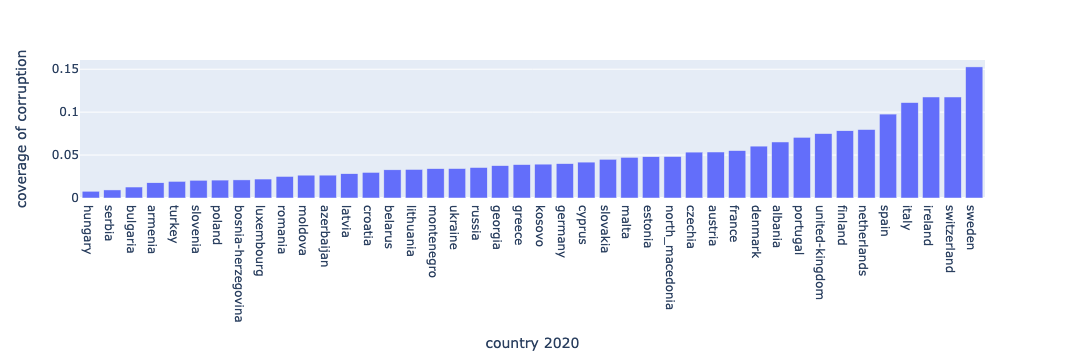

In [109]:
fig = px.bar(a_sorted_df, x='country', y='normalized_count')
fig.update_layout(yaxis_title=f'coverage of {attribute}')
fig.update_layout(xaxis_title=f'country {year}')
fig.show()

In [129]:
# plot corpus sizes for all countries
year = '2020'
filtered_df = corpus_df[(corpus_df['year'] == year) & (corpus_df['corpus_size'] > 0)]
sorted_df = filtered_df.sort_values('corpus_size')
max_corpus = sorted_df['corpus_size'].max()
sorted_df['normalized_corpus'] = sorted_df['corpus_size'].apply(lambda x: x/max_corpus)
sorted_df['normalized_corpus'] = sorted_df['normalized_corpus'].astype(float)
data = { 'country': [], 'compound_metric1': [], 'compound_metric2': [], 'normalized_count':[], 'normalized_corpus':[]}
for i, row in a_sorted_df.iterrows():
    
    country = row['country']
    corpus_row = sorted_df[sorted_df['country'] == country]
    norm_corpus = corpus_row['normalized_corpus'].values[0]
    xx = a_sorted_df.loc[i]['normalized_count']
    data['country'].append(country)
    data['compound_metric1'].append(xx / (norm_corpus))
    data['compound_metric2'].append((xx * norm_corpus)**2)
    data['normalized_count'].append(xx)
    data['normalized_corpus'].append(norm_corpus)
    #a_sorted_df.loc[i]['compound_metric'] =  xx * norm_corpus

new_df = pd.DataFrame(data)
new_sorted_df = new_df.sort_values('compound_metric1')
print(new_sorted_df)

               country  compound_metric1  compound_metric2  normalized_count  \
0              hungary          0.008808          0.000050          0.007881   
2             bulgaria          0.014384          0.000129          0.012788   
1               serbia          0.016176          0.000030          0.009383   
5             slovenia          0.025419          0.000281          0.020649   
6               poland          0.025477          0.000292          0.020871   
4               turkey          0.031153          0.000145          0.019355   
3              armenia          0.032870          0.000092          0.017751   
7   bosnia-herzegovina          0.033868          0.000172          0.021080   
13             croatia          0.037164          0.000572          0.029808   
9              romania          0.037596          0.000280          0.025078   
11          azerbaijan          0.040045          0.000313          0.026620   
10             moldova          0.040435

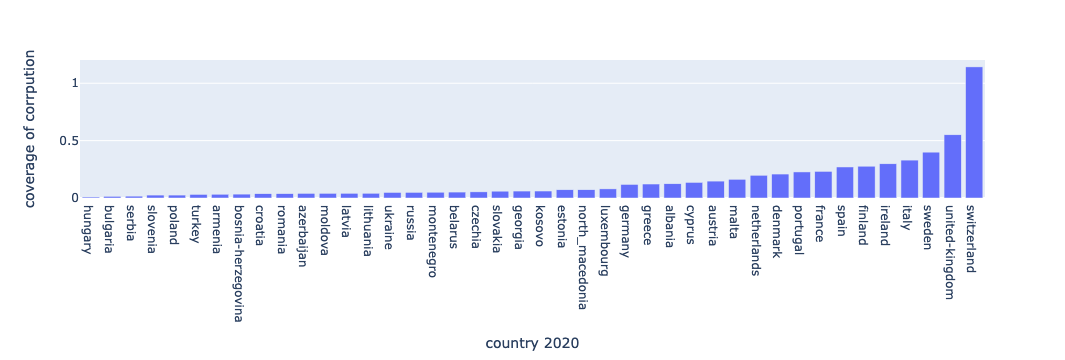

In [130]:
fig = px.bar(new_sorted_df, x='country', y='compound_metric1')
fig.update_layout(yaxis_title=f'coverage of corrpution')
fig.update_layout(xaxis_title=f'country {year}')
fig.show()

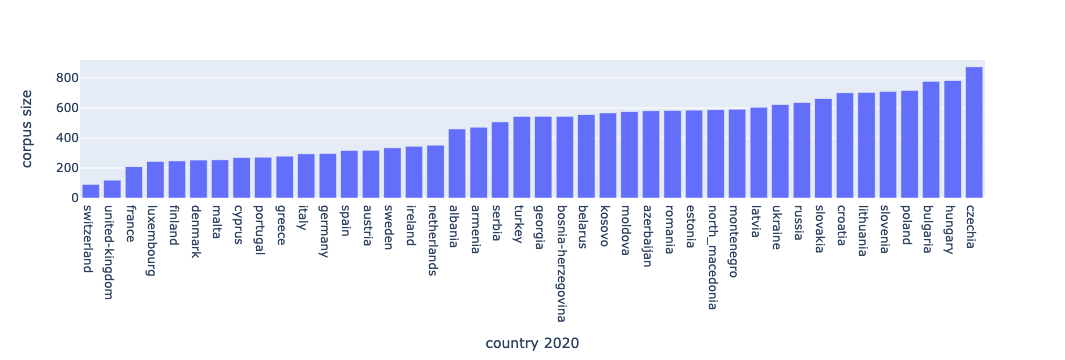

In [84]:
fig = px.bar(sorted_df, x='country', y='corpus_size')
fig.update_layout(yaxis_title='corpus size')
fig.update_layout(xaxis_title=f'country {year}')
fig.show()